In [38]:
# import system libs
import os

import zipfile
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, save_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


## **Functions needed**

**function to create dataframe**

In [39]:
# Define image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)
def oversample_minority_classes(data_dir):
    output_dir = '/kaggle/working/augmented_dataset'
    os.makedirs(output_dir, exist_ok=True)
    
    class_counts = {}
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        if os.path.isdir(foldpath):
            class_counts[fold] = len(filelist)
    max_count = max(class_counts.values())

    for class_name, count in class_counts.items():
        class_path = os.path.join(data_dir, class_name)
        target_path = os.path.join(output_dir, class_name)
        os.makedirs(target_path, exist_ok=True)
        
        images = [os.path.join(class_path, fname) for fname in os.listdir(class_path) if fname.endswith('.jpg')]
        
        additional_images_needed = 500
        for i in range(additional_images_needed):
            img_path = images[i % len(images)]
            img = tf.keras.preprocessing.image.load_img(img_path)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for datagen flow
            # Generate new file name and save the duplicated image
            # Generate augmented images and save
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=target_path, 
                                      save_prefix='aug', save_format='jpg'):
                break  # Save one augmented image per iteration
            # new_img_path = os.path.join(target_path, f"dup_{i}.jpg")
            # save_img(new_img_path, img_array)

    # Zip the directory
    zip_path = '/kaggle/working/augmented_dataset.zip'
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for root, _, files in os.walk(output_dir):
            for file in files:
                zipf.write(os.path.join(root, file), 
                           os.path.relpath(os.path.join(root, file), 
                                           output_dir))


                

# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
        

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

**Function to genrate images from dataframe**

In [40]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

**Function to display data sample**

In [41]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

**Callbacks**

Callbacks : Helpful functions to help optimize model training
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [42]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self ,patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss


    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.learning_rate)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    self.model.optimizer.learning_rate.assign(lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    self.model.optimizer.learning_rate.assign(lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

**Function to plot history of training**

In [43]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

**Function to create Confusion Matrix**

In [44]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

## Model Structure

**Start Reading Dataset**

In [45]:
# data_dir = '/kaggle/input/dataset/Dataset/'


# oversample_minority_classes(data_dir)

In [46]:
# import kagglehub

# # Download latest version
# data_dir = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

# print("Path to dataset files:", data_dir)
data_dir = '/kaggle/input/datasetv2/augmented_dataset'


# Get splitted data
train_df, valid_df, test_df = split_data(data_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)



Found 4344 validated image filenames belonging to 3 classes.
Found 543 validated image filenames belonging to 3 classes.
Found 543 validated image filenames belonging to 3 classes.


**Display image Sample**

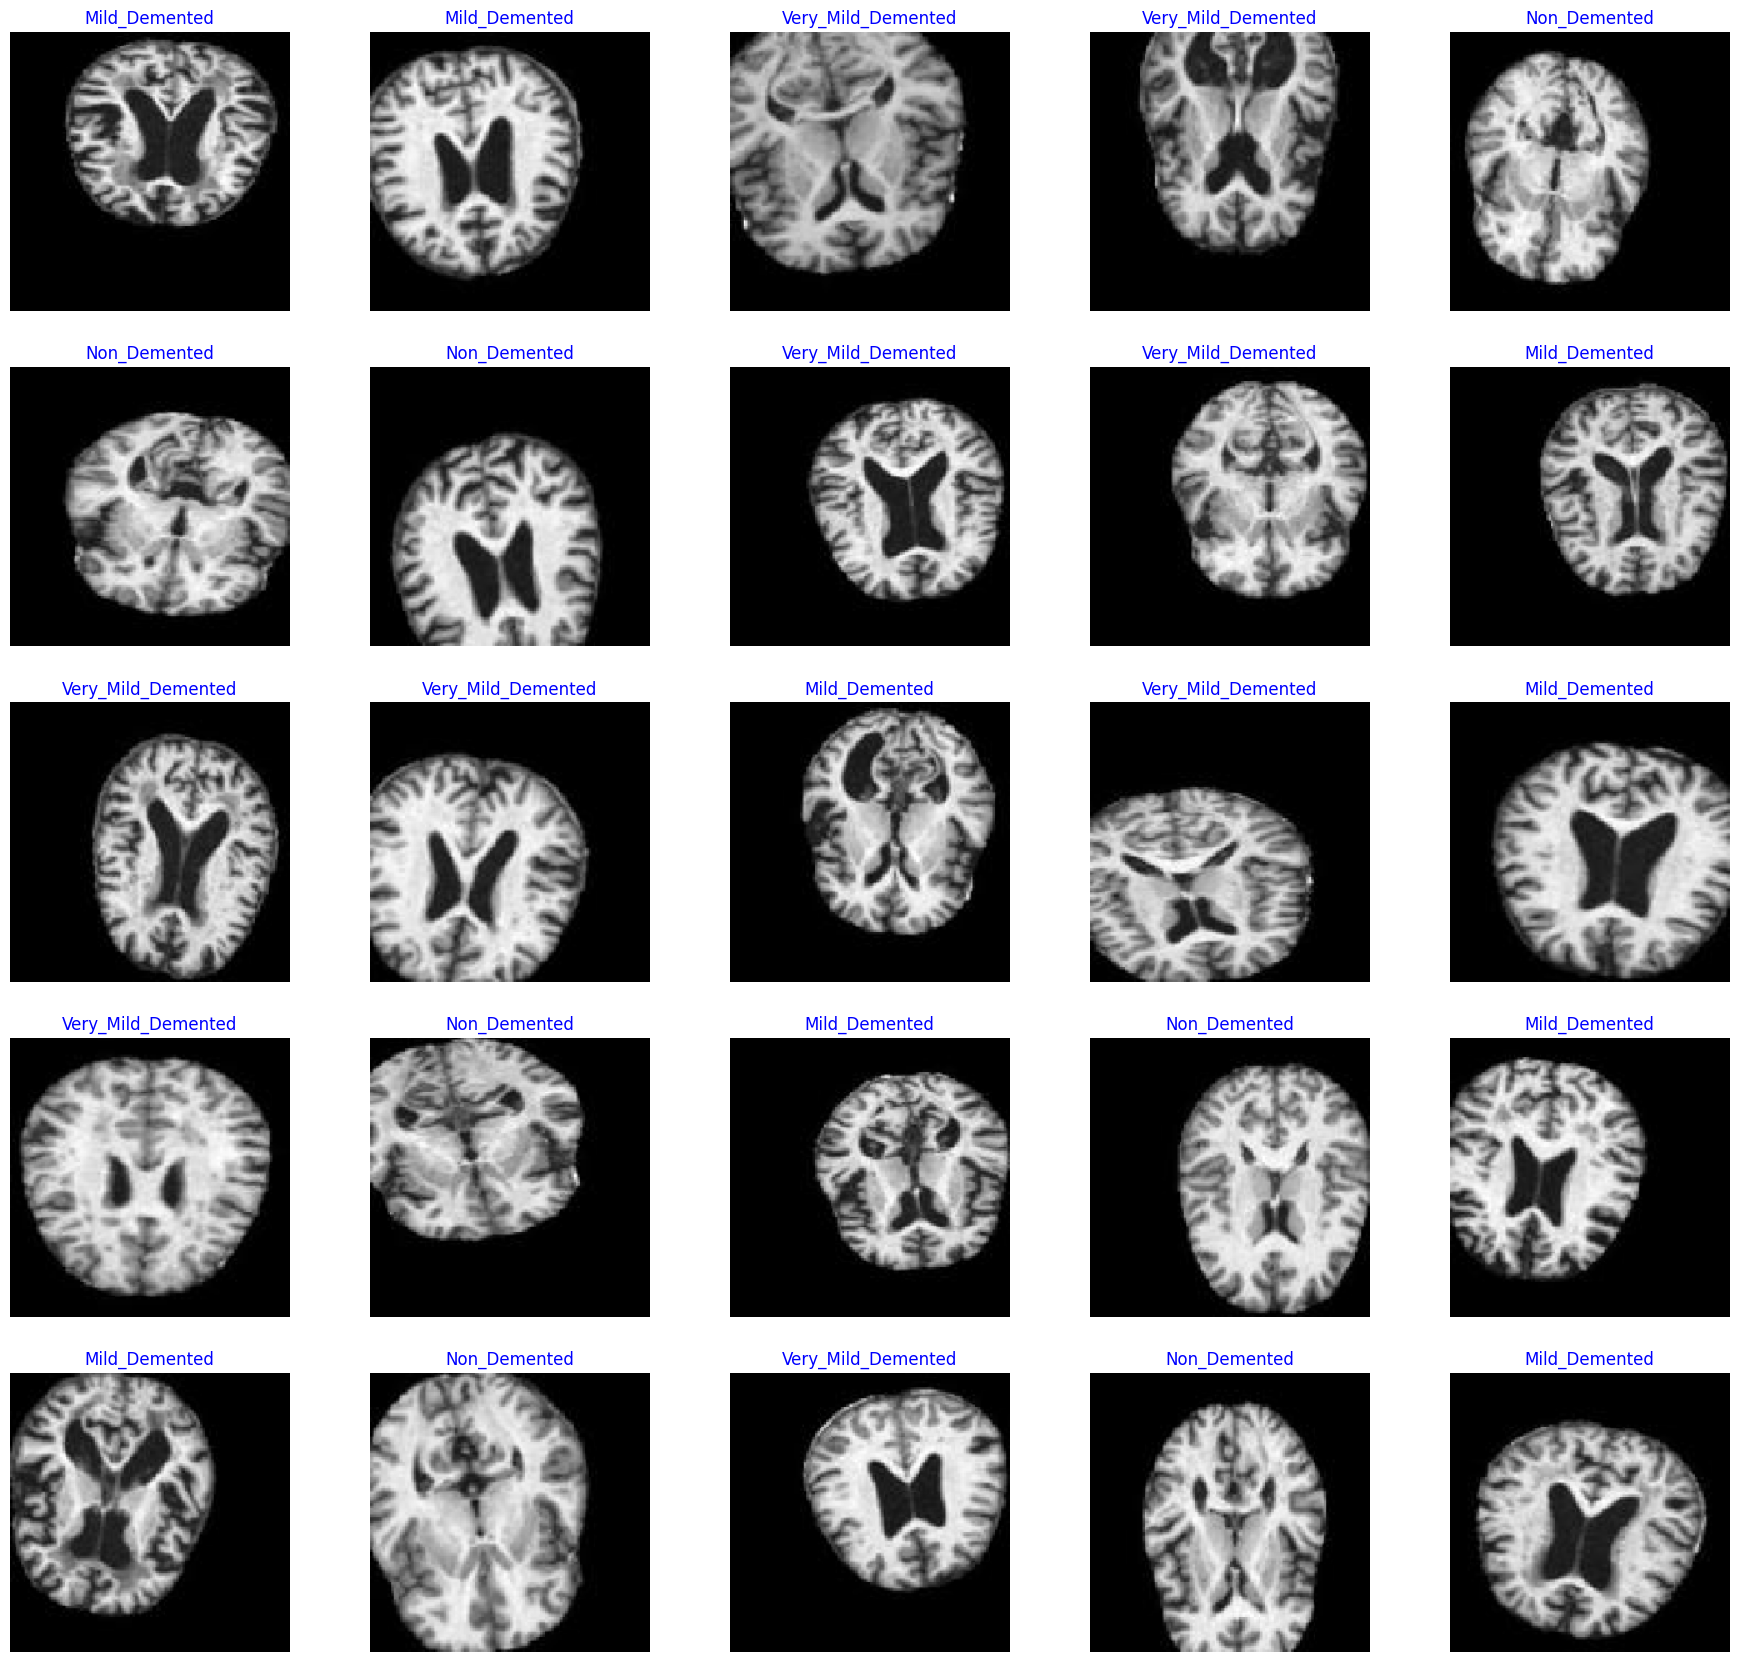

In [47]:
show_images(train_gen)

**Generic Model Creation**

**Set Callback Parameters**

In [48]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.5),
    # Fully Connected Layer 2
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(class_count, activation='softmax')
])

# Build the model with a defined input shape
model.build(input_shape=(None, *img_shape))  # Adjust input shape here

model.compile(optimizer= Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,211,826 (42.77 MB)

 Trainable params: 11,123,755 (42.43 MB)

 Non-trainable params: 88,071 (344.03 KB)

In [49]:
batch_size = 40   # set batch size for training
epochs = 100   # number of all epochs in training
patience = 2   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 10   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

**Train model**

In [50]:
# from sklearn.utils import class_weight


# Create a dictionary of the class weights

# Use the class weights in model training
# #history = model.fit(x=train_gen, 
#                     epochs=epochs, 
#                     verbose=0, 
#                     callbacks=callbacks,
#                     validation_data=valid_gen, 
#                     validation_steps=None, 
#                     shuffle=False)  # <- Adding class weights here

# Training the model

# class_weight = {0: 5.0, 1: 15.0, 2: 1.0, 3: 1.0}
# Class 3 somewhat represented)

history = model.fit(train_gen, validation_data = valid_gen, batch_size = 64, epochs= 100, verbose = 0,callbacks=callbacks)


Do you want model asks you to halt the training [y/n] ?


 y


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /100    1.473   37.017   1.25080  38.306   0.00010  0.00010  accuracy     0.00    253.57 
 2 /100    1.204   46.363   1.26043  41.436   0.00010  0.00010  accuracy    25.25    29.55  
 3 /100    1.103   51.128   1.23960  42.541   0.00010  0.00010  accuracy    10.28    29.56  
 4 /100    1.009   54.167   1.45625  34.438   0.00010  0.00010  accuracy     5.94    29.58  
 5 /100    0.935   57.436   1.80886  34.254   0.00010  0.00010  accuracy     6.03    29.61  
enter H to halt training or an integer for number of epochs to run then ask again


 10


 training will continue until epoch 15
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /100    0.864   61.119   0.98134  56.354   0.00010  0.00010  accuracy     6.41    29.60  
 7 /100    0.784   65.308   0.91794  58.011   0.00010  0.00010  accuracy     6.85    29.57  
 8 /100    0.736   66.459   0.87071  62.983   0.00010  0.00010  accuracy     1.76    29.64  
 9 /100    0.661   72.353   0.84474  63.168   0.00010  0.00010  accuracy     8.87    29.63  
10 /100    0.571   75.875   0.93008  63.904   0.00010  0.00010  accuracy     4.87    29.65  
11 /100    0.508   78.913   0.76840  68.877   0.00010  0.00010  accuracy     4.00    29.59  
12 /100    0.423   83.057   0.79800  68.324   0.00010  0.00010  accuracy     5.25    29.52  
13 /100    0.350   86.579   0.78003  71.455   0.00010  0.00010  accuracy     4.24    29.66  
14 /100    0.282   89.365   0.72486  72.560   0.00010  0.00010  accuracy     3.22    29.84  
15 /100    0.238   91.068   0.76

 3


 training will continue until epoch 18
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
16 /100    0.201   92.703   0.69000  75.506   0.00010  0.00010  val_loss     4.81    29.65  
17 /100    0.170   93.808   0.68063  78.085   0.00010  0.00010  val_loss     1.36    29.75  
18 /100    0.161   94.268   0.72819  76.427   0.00010  0.00010  val_loss    -6.99    29.81  
enter H to halt training or an integer for number of epochs to run then ask again


 2


 training will continue until epoch 20
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
19 /100    0.137   95.120   0.66514  78.085   0.00010  0.00010  val_loss     2.28    52.77  
20 /100    0.123   95.879   0.64211  79.926   0.00010  0.00010  val_loss     3.46    29.78  
enter H to halt training or an integer for number of epochs to run then ask again


 2


 training will continue until epoch 22
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
21 /100    0.122   95.856   0.64077  79.558   0.00010  0.00010  val_loss     0.21    29.73  
22 /100    0.105   96.340   0.62184  79.742   0.00010  0.00010  val_loss     2.95    29.82  
enter H to halt training or an integer for number of epochs to run then ask again


 2


 training will continue until epoch 24
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
23 /100    0.086   97.145   0.66091  79.006   0.00010  0.00010  val_loss    -6.28    29.71  
24 /100    0.089   97.261   0.59835  81.584   0.00010  0.00010  val_loss     3.78    29.76  
enter H to halt training or an integer for number of epochs to run then ask again


 h


training has been halted at epoch 24 due to user input
training elapsed time was 0.0 hours, 27.0 minutes, 5.22 seconds)


**Display model performance**

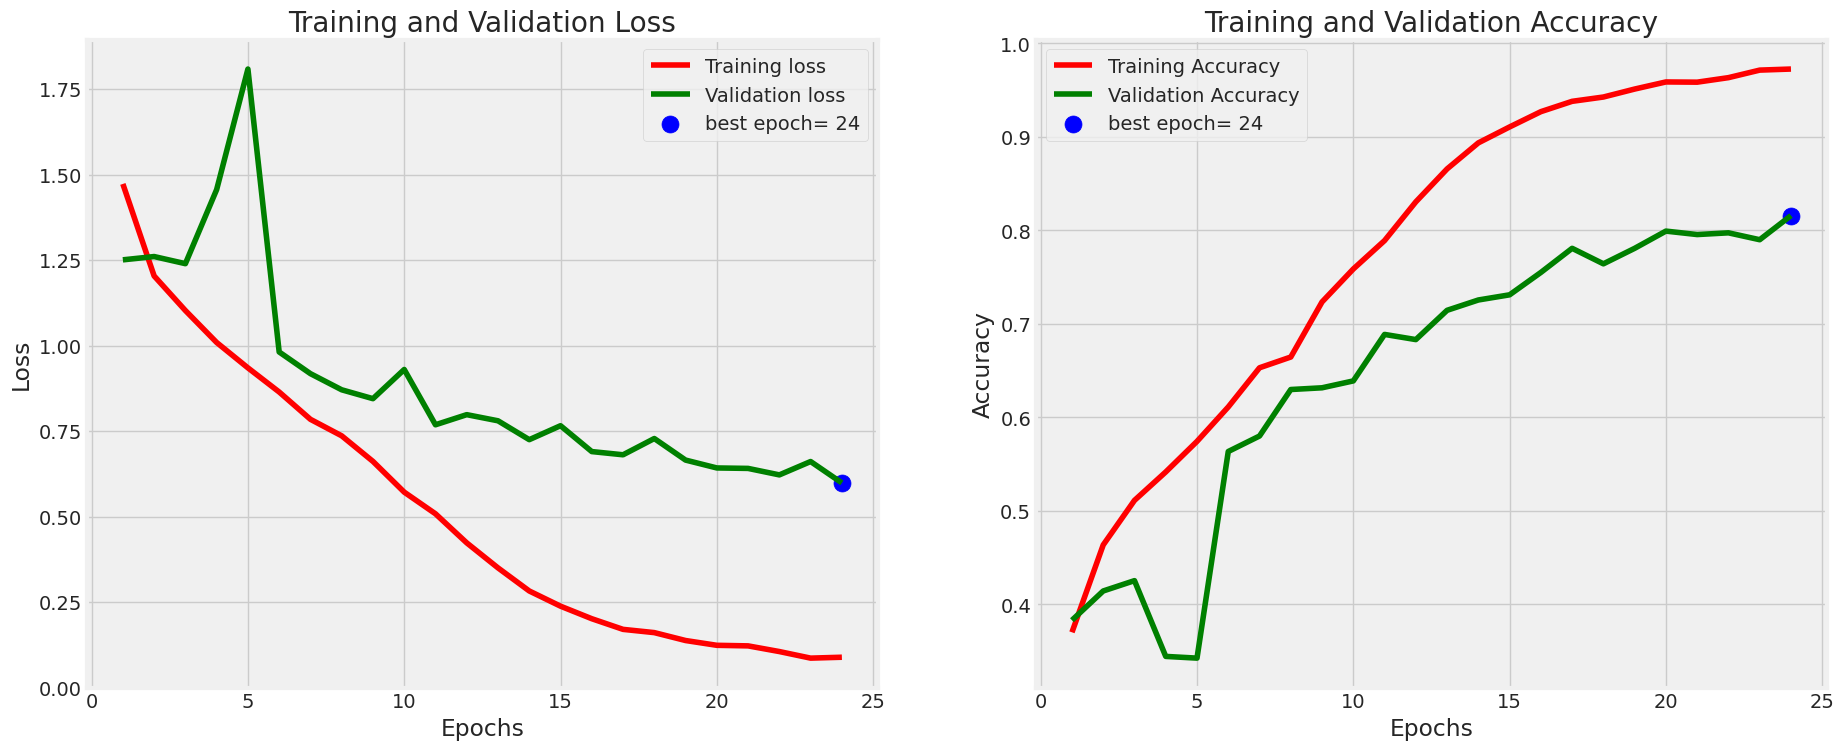

In [51]:
plot_training(history)

In [52]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 1.0000 - loss: 0.0038
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8150 - loss: 0.6004  
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7986 - loss: 0.5982
Train Loss:  0.0038503683172166348
Train Accuracy:  1.0
--------------------
Validation Loss:  0.59835284948349
Validation Accuracy:  0.8158379197120667
--------------------
Test Loss:  0.5044925212860107
Test Accuracy:  0.8268876671791077


In [88]:
preds = model.predict(test_gen)  # Use model.predict() instead of predict_generator()
y_pred = np.argmax(preds, axis=1)  # Get the indices of the maximum values along axis 1
print(y_pred)
print(test_gen)


181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
[2 2 0 2 1 0 0 0 2 0 2 2 1 1 0 2 1 0 0 1 1 0 2 2 2 1 1 2 1 1 2 2 1 2 0 1 0
 0 2 0 2 2 2 0 2 1 2 2 1 0 1 1 2 0 1 1 0 1 2 0 2 2 2 0 0 2 0 0 1 2 0 2 0 2
 0 2 2 0 0 2 0 2 2 0 0 1 1 2 1 2 2 0 0 0 2 2 2 0 2 0 1 0 1 1 1 0 1 0 2 2 1
 0 0 2 2 1 0 1 2 2 0 2 0 1 2 0 0 0 2 2 1 1 0 2 0 2 0 2 2 2 2 1 2 0 1 1 0 1
 2 0 1 0 1 1 1 1 2 1 2 2 1 2 1 1 1 0 2 2 2 1 0 0 1 0 2 2 2 0 1 0 0 0 0 0 0
 0 1 1 0 1 0 0 2 1 1 2 0 0 1 1 0 0 0 0 0 1 2 2 2 0 0 2 2 2 1 2 0 1 1 1 2 2
 2 0 0 2 2 2 0 1 1 1 1 1 0 2 2 0 1 1 1 2 1 2 2 0 1 0 1 2 2 2 2 0 1 0 2 1 0
 1 0 2 0 2 2 2 0 0 2 1 0 2 0 1 1 2 2 2 1 1 0 0 2 2 1 2 0 0 1 1 1 0 0 1 1 2
 0 2 2 0 0 1 1 2 2 1 2 0 0 0 0 1 0 0 0 2 1 2 0 2 1 0 2 1 1 1 2 1 2 0 0 0 0
 1 0 2 2 0 1 2 2 2 2 0 2 1 1 2 2 1 2 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 2
 1 0 1 2 1 2 0 0 2 1 2 1 0 2 0 2 1 2 2 0 2 2 0 0 2 2 2 1 2 0 1 1 1 0 2 0 0
 2 2 0 2 2 1 2 2 0 1 1 1 0 2 0 0 2 1 2 0 0 2 1 1 1 0 0 0 2 0 1 2 0 0 0 2 1
 0 0 2 2 1 1 2 1 1 1 2 1 1 2 0 2 1 0 1 0 2 0 0 2 1 0 2 2 0 

Confusion Matrix, Without Normalization
[[164   5  14]
 [  6 140  34]
 [ 17  18 145]]
                    precision    recall  f1-score   support

     Mild_Demented       0.88      0.90      0.89       183
      Non_Demented       0.86      0.78      0.82       180
Very_Mild_Demented       0.75      0.81      0.78       180

          accuracy                           0.83       543
         macro avg       0.83      0.83      0.83       543
      weighted avg       0.83      0.83      0.83       543



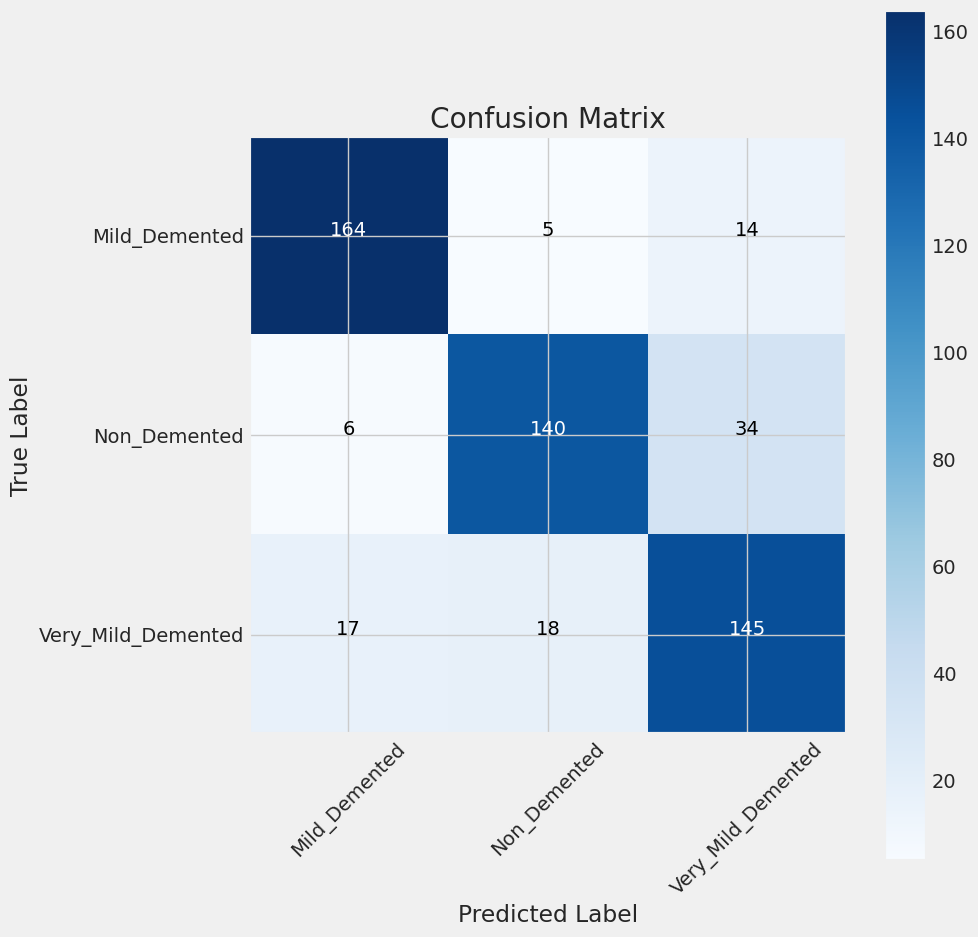

In [54]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [82]:
# Save the entire model in SavedModel format
model.save('/kaggle/working/my_model2.h5')


AttributeError: 'History' object has no attribute 'save'

In [97]:
# Step 1: Import libraries (Kaggle has TensorFlow pre-installed)
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os

# Step 2: Load the .h5 model
# Assuming the .h5 model is uploaded to the Kaggle environment
model = load_model('/kaggle/working/my_model.h5')

# Step 3: Preprocess input data
# Let's assume you're working with images as input data
img_path ='/kaggle/input/datasetv2/augmented_dataset/Very_Mild_Demented/aug_0_1007.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Update target_size according to your model
img_array = image.img_to_array(img)   # Normalize the image
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Step 4: Run prediction
predictions = model.predict(img_array)

# Step 5: Post-process predictions (Assuming classification task)
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class}')

# Optional: If your model outputs probabilities, you can print them as well
print(f'Prediction probabilities: {predictions}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: [2]
Prediction probabilities: [[1.9105952e-05 1.2559845e-04 9.9985528e-01]]


In [100]:
# Let's assume you're working with images as input data
img_path ='/kaggle/input/datasetv2/augmented_dataset/Non_Demented/aug_0_1003.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Update target_size according to your model
img_array = image.img_to_array(img)  # Normalize the image
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Step 4: Run prediction
predictions = model.predict(img_array)

# Step 5: Post-process predictions (Assuming classification task)
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class}')

# Optional: If your model outputs probabilities, you can print them as well
print(f'Prediction probabilities: {predictions}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class: [1]
Prediction probabilities: [[2.4895795e-04 9.9509472e-01 4.6563018e-03]]


In [101]:
# Let's assume you're working with images as input data
img_path ='/kaggle/input/datasetv2/augmented_dataset/Mild_Demented/aug_0_100.jpg'
    # define model parameters
img_size = (224, 224)
channels = 3 # either BGR or Grayscale
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)
# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Update target_size according to your model
img_array = image.img_to_array(img) # Normalize the image
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Step 4: Run prediction
predictions = model.predict(img_array)

# Step 5: Post-process predictions (Assuming classification task)
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class}')

# Optional: If your model outputs probabilities, you can print them as well
print(f'Prediction probabilities: {predictions}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class: [0]
Prediction probabilities: [[9.9897891e-01 3.3524539e-04 6.8580837e-04]]
